# Analyze Token Match Proportions from Pickle Results

This notebook finds, combines, and analyzes pickle result files generated by `compute_p_match.py` for token match proportions. It searches for files with a given prefix and generation length, combines their results, and plots a histogram of the 'proportions' values.

In [1]:
# Import Required Libraries
import os
import glob
import pickle
import matplotlib.pyplot as plt


In [2]:
import numpy as np

In [3]:
# Define Parameters for File Search
prefix_len = 200  # Change as needed
generation_len = 100  # Change as needed


In [4]:
# Find and Load Pickle Files
pattern = f"results_prefix{prefix_len}_gen{generation_len}_start*_end*.pkl"
pickle_files = glob.glob(pattern)
print(f"Found {len(pickle_files)} pickle files:", pickle_files)

loaded_results = []
for file in pickle_files:
    with open(file, "rb") as f:
        loaded_results.append(pickle.load(f))

Found 2 pickle files: ['results_prefix200_gen100_start0_end50000.pkl', 'results_prefix200_gen100_start50000_end349997.pkl']


In [5]:
# Combine Results from Pickle Files
all_proportions = []
for result in loaded_results:
    if 'proportions' in result:
        all_proportions.extend(result['proportions'])
print(f"Total proportions combined: {len(all_proportions)}")

Total proportions combined: 116991


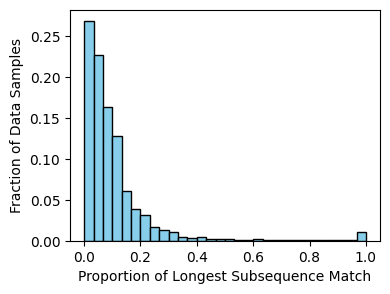

In [6]:
# Plot Histogram of Proportions
plt.figure(figsize=(4, 3))
counts, bins, patches = plt.hist(all_proportions, bins=30, color='skyblue', edgecolor='black', density=False)
total_samples = len(all_proportions)
plt.clf()
plt.bar(bins[:-1], counts / total_samples, width=(bins[1]-bins[0]), color='skyblue', edgecolor='black', align='edge')
plt.xlabel('Proportion of Longest Subsequence Match')
plt.ylabel('Fraction of Data Samples')
plt.show()

# Print examples

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from config import hf_cache_dir

olmo = AutoModelForCausalLM.from_pretrained(
    "allenai/OLMo-2-1124-7B", cache_dir=hf_cache_dir, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained("allenai/OLMo-2-1124-7B")

/n/home04/cfang/.conda/envs/axolotl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]


In [8]:
from datasets import load_dataset

ds = load_dataset("allenai/dolmino-mix-1124", "flan", cache_dir=hf_cache_dir)

In [9]:
# Find and Print High-Match Examples
from difflib import SequenceMatcher

high_match_indices = [i for i, p in enumerate(all_proportions) if p >= 0.8]
print(f"Found {len(high_match_indices)} examples with proportion >= 0.8.")
num_to_show = min(10, len(high_match_indices))
shown = 0
for result in loaded_results:
    for i, proportion in zip(result['index'], result['proportions']):
        if proportion >= 0.8 and shown < num_to_show:
            paragraph = ds['train']['text'][i]
            tokenized_paragraph = tokenizer(paragraph, return_tensors='pt', return_token_type_ids=False)
            n_paragraph_tokens = tokenized_paragraph['input_ids'].shape[1]
            if n_paragraph_tokens < prefix_len+generation_len:
                continue
            paragraph_prefix = {
                'input_ids': tokenized_paragraph['input_ids'][:, :prefix_len],
                'attention_mask': tokenized_paragraph['attention_mask'][:, :prefix_len]}
        
            # Generate the next GENERATION_LEN tokens using greedy sampling
            response = olmo.generate(**paragraph_prefix, max_new_tokens=generation_len, do_sample=False)
            n_tokens_actually_generated = response.shape[1] - prefix_len
        
            # Decode the generated tokens and the actual tokens
            generated_tokens = tokenizer.convert_ids_to_tokens(response[0, prefix_len:])
            actual_tokens = tokenizer.convert_ids_to_tokens(
                tokenized_paragraph['input_ids'][0, prefix_len:prefix_len+n_tokens_actually_generated])
        
            # Find the longest matching subsequence on a token-by-token level
            matcher = SequenceMatcher(None, generated_tokens, actual_tokens)
            match = matcher.find_longest_match(0, len(generated_tokens), 0, len(actual_tokens))
            correct_predictions = match.size
            total_predictions = len(actual_tokens)
        
            # Calculate the proportion of correct predictions for this example
            recalc_proportion = correct_predictions / total_predictions if total_predictions > 0 else 0

            print("="*50)
            print(f"\nExample index: {i}")
            print(f"Proportion: {recalc_proportion:.2f} and {proportion}")
            prefix = tokenizer.decode(response[0, :prefix_len])
            decoded_generated = tokenizer.decode(response[0, prefix_len:])
            decoded_actual = tokenizer.decode(
                tokenized_paragraph['input_ids'][0, prefix_len:prefix_len+n_tokens_actually_generated])
            print('-'*50)
            print(f'[{prefix}]{decoded_generated}')
            print('-'*50)
            print(f'[{prefix}]{decoded_actual}')
            print("="*50)
            print()
            shown += 1
        if shown >= num_to_show:
            break
    if shown >= num_to_show:
        break

Found 1555 examples with proportion >= 0.8.


/n/home04/cfang/.conda/envs/axolotl/lib/python3.12/site-packages/transformers/generation/utils.py:2479: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(



Example index: 476
Proportion: 1.00 and 1.0
--------------------------------------------------
[Student A:Veni, vidi, vici (Classical Latin: ( ˈweːniː ˈwiːdiː ˈwiːkiː); Ecclesiastical Latin: (ˈvɛni ˈvidi ˈvitʃi); "I came; I saw; I conquered" ) is a Latin phrase popularly attributed to Julius Caesar who, according to Appian, used the phrase in a letter to the Roman Senate around 47 BC after he had achieved a quick victory in his short war against Pharnaces II of Pontus at the Battle of Zela. The phrase is used to refer to a swift, conclusive victory.

I cam i saw i conquered in latin?
Student B:OK... To answer the question, consider the following: Veni, vidi, vici (Classical Latin: ( ˈweːniː �]�wiːdiː ˈwiːkiː); Ecclesiastical Latin: (ˈvɛni ˈvidi ˈvitʃi); "I came; I saw; I conquered" ) is a Latin phrase popularly attributed to Julius Caesar who, according to Appian, used the phrase in a letter to the Roman Senate around 47 BC after he had achieved a quick victory in his short war agains

In [10]:
# Find and Print High-Match Examples
from difflib import SequenceMatcher

num_to_show = 10
shown = 0
for result in loaded_results:
    for i, proportion in zip(result['index'], result['proportions']):
        if proportion < 0.15 and shown < num_to_show:
            paragraph = ds['train']['text'][i]
            tokenized_paragraph = tokenizer(paragraph, return_tensors='pt', return_token_type_ids=False)
            n_paragraph_tokens = tokenized_paragraph['input_ids'].shape[1]
            if n_paragraph_tokens < prefix_len+generation_len:
                continue
            paragraph_prefix = {
                'input_ids': tokenized_paragraph['input_ids'][:, :prefix_len],
                'attention_mask': tokenized_paragraph['attention_mask'][:, :prefix_len]}
        
            # Generate the next GENERATION_LEN tokens using greedy sampling
            response = olmo.generate(**paragraph_prefix, max_new_tokens=generation_len, do_sample=False)
            n_tokens_actually_generated = response.shape[1] - prefix_len
        
            # Decode the generated tokens and the actual tokens
            generated_tokens = tokenizer.convert_ids_to_tokens(response[0, prefix_len:])
            actual_tokens = tokenizer.convert_ids_to_tokens(
                tokenized_paragraph['input_ids'][0, prefix_len:prefix_len+n_tokens_actually_generated])
        
            # Find the longest matching subsequence on a token-by-token level
            matcher = SequenceMatcher(None, generated_tokens, actual_tokens)
            match = matcher.find_longest_match(0, len(generated_tokens), 0, len(actual_tokens))
            correct_predictions = match.size
            total_predictions = len(actual_tokens)
        
            # Calculate the proportion of correct predictions for this example
            recalc_proportion = correct_predictions / total_predictions if total_predictions > 0 else 0

            print("="*50)
            print(f"\nExample index: {i}")
            print(f"Proportion: {recalc_proportion:.2f} and {proportion}")
            prefix = tokenizer.decode(response[0, :prefix_len])
            decoded_generated = tokenizer.decode(response[0, prefix_len:])
            decoded_actual = tokenizer.decode(
                tokenized_paragraph['input_ids'][0, prefix_len:prefix_len+n_tokens_actually_generated])
            print('-'*50)
            print(f'[{prefix}]{decoded_generated}')
            print('-'*50)
            print(f'[{prefix}]{decoded_actual}')
            print("="*50)
            print()
            shown += 1
        if shown >= num_to_show:
            break
    if shown >= num_to_show:
        break


Example index: 6
Proportion: 0.09 and 0.09
--------------------------------------------------
[QUESTION: Premise: "A woman is waiting to cross the road."
Hypothesis: "The woman is waiting near the road."
Is the hypothesis entailed by the premise?
Options:
- yes
- it is not possible to tell
- no

Let's solve it slowly: Waiting near the road apparently indicates that the woman is waiting to cross the road.
The answer is yes.
[QUESTION] Premise: "A child dressed in blue riding her yellow bike quickly down the road."
Hypothesis: "A boy digs a hole."
Is the hypothesis entailed by the premise?
Options:
- yes
- it is not possible to tell
- no
Her refers to a girl and cannot be a boy. One cannot be riding a bike and digging a hole simultaneously.
The answer is no.
Q: Can we conclude from "A small boy is building with some wooden blocks." that "A boy is building something."?
Options:
- yes
- no
-] it is not possible to tell
A: yes
Premise & Hypothesis & Options: A man in a blue shirt is standi

In [11]:
# Find and Print High-Match Examples
from difflib import SequenceMatcher

num_to_show = 10
shown = 0
for result in loaded_results:
    for i, proportion in zip(result['index'], result['proportions']):
        if (0.4 < proportion < 0.5) and shown < num_to_show:
            paragraph = ds['train']['text'][i]
            tokenized_paragraph = tokenizer(paragraph, return_tensors='pt', return_token_type_ids=False)
            n_paragraph_tokens = tokenized_paragraph['input_ids'].shape[1]
            if n_paragraph_tokens < prefix_len+generation_len:
                continue
            paragraph_prefix = {
                'input_ids': tokenized_paragraph['input_ids'][:, :prefix_len],
                'attention_mask': tokenized_paragraph['attention_mask'][:, :prefix_len]}
        
            # Generate the next GENERATION_LEN tokens using greedy sampling
            response = olmo.generate(**paragraph_prefix, max_new_tokens=generation_len, do_sample=False)
            n_tokens_actually_generated = response.shape[1] - prefix_len
        
            # Decode the generated tokens and the actual tokens
            generated_tokens = tokenizer.convert_ids_to_tokens(response[0, prefix_len:])
            actual_tokens = tokenizer.convert_ids_to_tokens(
                tokenized_paragraph['input_ids'][0, prefix_len:prefix_len+n_tokens_actually_generated])
        
            # Find the longest matching subsequence on a token-by-token level
            matcher = SequenceMatcher(None, generated_tokens, actual_tokens)
            match = matcher.find_longest_match(0, len(generated_tokens), 0, len(actual_tokens))
            correct_predictions = match.size
            total_predictions = len(actual_tokens)
        
            # Calculate the proportion of correct predictions for this example
            recalc_proportion = correct_predictions / total_predictions if total_predictions > 0 else 0

            print("="*50)
            print(f"\nExample index: {i}")
            print(f"Proportion: {recalc_proportion:.2f} and {proportion}")
            prefix = tokenizer.decode(response[0, :prefix_len])
            decoded_generated = tokenizer.decode(response[0, prefix_len:])
            decoded_actual = tokenizer.decode(
                tokenized_paragraph['input_ids'][0, prefix_len:prefix_len+n_tokens_actually_generated])
            print('-'*50)
            print(f'[{prefix}]{decoded_generated}')
            print('-'*50)
            print(f'[{prefix}]{decoded_actual}')
            print("="*50)
            print()
            shown += 1
        if shown >= num_to_show:
            break
    if shown >= num_to_show:
        break

/n/home04/cfang/.conda/envs/axolotl/lib/python3.12/site-packages/transformers/generation/utils.py:2479: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(



Example index: 156
Proportion: 0.46 and 0.46
--------------------------------------------------
[Q: Trey is hanging wall decorations around his house. He uses a nail for each of two-thirds of them, a thumbtack for each of two-fifths of the rest, and a sticky strip for each of the other decorations. He used 15 sticky strips. How many nails did Trey use?
A: Trey used 15 sticky strips for 3 / 5 of the remaining decorations after using nails, so he used 15 *  / 3 / 5 = 25 thumbtacks and sticky strips. The 25 decorations were 1 / 3 of the total decorations, so he used 25 / 1 / 3 = 75 total decorations. The nails were 2 / 3 of the decorations, so Trey used 75 decorations * 2 / 3 = 50 nails. The answer is 50.

Q: Caleb is baking a birthday cake for his grandfather. His grandfather is turning 79 years old. Caleb puts three colors] of candles on the cake. He puts one candle for each year for his grandfather. He puts 27 yellow candles, 14 red candles and the rest are blue candles. How many blue